# Kaggle Groupe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import ExtraTreesClassifier

from sklearn import ensemble
from sklearn import datasets

C:\Users\natacha\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
train.info()

In [ ]:
train.describe()

In [ ]:
train_object = train.select_dtypes(exclude=['floating','float64','int64'])   

train_object = pd.concat([train_object,train['SalePrice']], axis=1)

train_numeric = train.select_dtypes(include=['floating','float64','int64'])

In [ ]:
sns.distplot(train['SalePrice'])

In [ ]:
total = train_numeric.isnull().sum().sort_values(ascending=False)
percent = (train_numeric.isnull().sum()/train_numeric.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

On drop la colonne LotFrontage car trop de valeurs manquantes.
On remplace la colonne GarageYrBlt par hasgarage.
MasVnrArea = on remplace par zéro car correspond à pas de veneer.

In [ ]:
sns.clustermap(train_numeric.corr())

In [ ]:
columns_train_object =['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'SalePrice']

fig, axs = plt.subplots(nrows = len(columns_train_object), ncols=3, figsize = (30,15* len(columns_train_object)))

for i, x in enumerate(columns_train_object):
    sns.barplot(x, 'SalePrice', data=train_object, ax=axs[i, 0])
    sns.boxplot(x, 'SalePrice', data=train_object, ax=axs[i, 1])
    sns.countplot(x, data =train_object, ax=axs[i , 2])

# Missing Values :

In [ ]:
total = train_object.isnull().sum().sort_values(ascending=False)
percent = (train_object.isnull().sum()/train_object.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

On drop les colonnes : PoolQC, MiscFeature, Alley, Fence
FireplaceQu = pas de cheminée
GarageCond, GarageQual, GarageFinish, GarageType : on remplmace les vides par NoGarage

On enlève les colonnes : 
BsmtFinType2 
BsmtExposure 

On remplace les données manquantes par : Nogarage
BsmtQual
BsmtCond
BsmtFinType1

MasVnrType = on remplace par NoVnr car correspond à pas de veneer.

Electrical
On remplace la données manquante par SBrkr car correspond à la majorité des cas.

Pas de retraitement:
LotConfig 
LandSlope 
Utilities 
RoofMatl 


# Retraitements

In [5]:
def prepare_data(df):
    
    #GarageYrBlt : On remplace la colonne par hasgarage.
    df['GarageYrBlt'].fillna(0, inplace=True)
    mask = df['GarageYrBlt'] > 0
    df['GarageYrBlt'] = mask
    
    
    #MasVnrArea : on remplace par zéro car correspond à pas de veneer.
    df['MasVnrArea'] = df["MasVnrArea"].fillna(0)
        
    #FireplaceQu = pas de cheminée
    df['FireplaceQu'] = df["FireplaceQu"].fillna('NV')
    
    #GarageCond, GarageQual, GarageFinish, GarageType, BsmtQual, BsmtCond, BsmtFinType1 : 
    #on remplmace les vides par NoGarage
    df[['GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']] = \
    df[['GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']].fillna('NV')


    #MasVnrType = on remplace par NoVnr car correspond à pas de veneer.
    df['MasVnrType'] = df["MasVnrType"].fillna('NV')
    
    # Electrical : On remplace la données manquante par SBrkr car correspond à la majorité des cas.
    df['Electrical'] = df["Electrical"].fillna('SBrkr')

    #On drop les colonnes : PoolQC, MiscFeature, Alley, Fence, LotFrontage, BsmtFinType2, BsmtExposure, Street,
    # Condition2, Condition1, Heating 
    df = df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'LotFrontage', 'BsmtFinType2', 'BsmtExposure', 
                 'Street', 'Condition2', 'Condition1', 'Heating', 'Utilities', 'BsmtHalfBath', 'MiscVal'  ], axis = 1)

    
    for i in range(df.shape[1]):
        if df.count()[i] < df.shape[0]:
            #print(i, df.columns[i], df.iloc[:,i].dtypes)
            if (df.iloc[:,i].dtypes == object):
                #print('object')
                df.iloc[:,i] = df.iloc[:,i].fillna('NV')
            elif (df.iloc[:,i].dtypes == int):
                #print('int')
                df.iloc[:,i] = df.iloc[:,i].fillna(np.mean(df.iloc[:,i]))
            elif (df.iloc[:,i].dtypes == float):
                #print('float')
                df.iloc[:,i] = df.iloc[:,i].fillna(np.mean(df.iloc[:,i]))
    
    
    cleanup_nums = {
                    "ExterQual": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "NV": -1},
                    "ExterCond": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "NV": -1},
                    "BsmtQual": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "NV": -1},
                    "BsmtCond": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "NV": -1},
                    "BsmtFinType1": {"GLQ": 5, "ALQ": 4, "BLQ": 3, "Rec": 2, "LwQ": 1, "Unf": 0, "NV": -1},
                    "BsmtFinType2": {"GLQ": 5, "ALQ": 4, "BLQ": 3, "Rec": 2, "LwQ": 1, "Unf": 0, "NV": -1},
                    "HeatingQC": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "NV": -1},
                    "KitchenQual": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "NV": -1},
                    "Functional": {"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0, "NV": -1},
                    "FireplaceQu": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "NV": -1},
                    "GarageFinish": {"Fin": 2, "RFn": 1, "Unf": 0, "NV": -1},
                    "GarageQual": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "NV": -1},
                    "GarageCond": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "NV": -1},
                    "MSZoning": {"RM": 6, "RP": 5, "RL": 4, "RH": 3, "I": 2, "FV": 1, "C (all)": 0, "NV": -1},
                    "Utilities": {"AllPub": 3, "NoSewr": 2, "NoSeWa": 1, "ELO": 0, "NV": -1},
                    "Neighborhood": {'MeadowV': 1,'IDOTRR':1,'BrDale':1,
                                     'BrkSide':2,'Edwards':2,'OldTown':2,
                                     'Sawyer':3,'Blueste':3,'SWISU':3,'NPkVill':3,'NAmes':3,'Mitchel':3,
                                     'SawyerW':4,'NWAmes':4,'Gilbert':4,'Blmngtn':4,'CollgCr':4,
                                     'Crawfor':5,'ClearCr':5,'Somerst':5,'Veenker':5,'Timber':5,
                                     'StoneBr':6,'NridgHt':6,'NoRidge':6, "NV": -1}

                   }


       
    df.replace(cleanup_nums, inplace=True)
    
    columns_to_encode = list(df.loc[:, df.dtypes == object])
    
    for column in columns_to_encode:
        le = preprocessing.LabelEncoder()
        le.fit(df[column])
        df[column] = le.transform(df[column]) 
        
    #columns_to_oneHot = list(['BldgType'])
    
    #for column in columns_to_oneHot:
     #   df = pd.get_dummies(df, columns=[column])
        
    
    return df



In [6]:
train = prepare_data(train)

In [ ]:
[print(i, list(train)[i], np.unique(train.iloc[:,i])) for i in range(1,101)]

In [7]:
# this is our test set
y = train['SalePrice']
X = train.drop(['Id', 'SalePrice'], 1)


# flatten y into a 1-D array
y = np.ravel(y)

# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
#Linear Regression
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print(regr.score(X_train, y_train))

predicted_regr = regr.predict(X_test)
print(regr.score(X_test, y_test))

0.8681885593987898
0.692731452750684


In [9]:
#regression Lasso
from sklearn.linear_model import Ridge
clf = Ridge(alpha=0.1)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))

predicted_clf = clf.predict(X_test)
print(clf.score(X_test, y_test))

0.8681885334469973
0.692747679559348


In [10]:
#regression Lasso
from sklearn.linear_model import Lasso
clf_lasso = linear_model.Lasso(alpha=1.0)
clf_lasso.fit(X_train, y_train)
print(clf_lasso.score(X_train, y_train))

predicted_clf_lasso = clf_lasso.predict(X_test)
print(clf_lasso.score(X_test, y_test))

0.8681885176282589
0.6927287765120667


C:\Users\natacha\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [11]:
#random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
#X_train, y_train = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
regrF = RandomForestRegressor(max_depth=5, random_state=0)
regrF.fit(X_train, y_train)
print(regrF.score(X_train, y_train))

predicted_regrF = regrF.predict(X_test)
print(regrF.score(X_test, y_test))

0.9006246492117138
0.8232426117897036


In [12]:
#Gradient Boosting Regressor
GBR = ensemble.GradientBoostingRegressor()
GBR.fit(X_train, y_train)
print(GBR.score(X_train, y_train))

predicted_GBR = GBR.predict(X_test)
print(GBR.score(X_test, y_test))

0.969153294958908
0.8796640222430829


Feature ranking:
1. feature 7: OverallQual (0.593147)
2. feature 6: Neighborhood (0.120602)
3. feature 22: GrLivArea (0.111952)
4. feature 18: TotalBsmtSF (0.052323)
5. feature 20: 1stFlrSF (0.025132)
6. feature 16: BsmtFinSF1 (0.019695)
7. feature 2: LotArea (0.009977)
8. feature 32: GarageCars (0.007986)
9. feature 25: BedroomAbvGr (0.007031)
10. feature 21: 2ndFlrSF (0.006670)
11. feature 33: GarageArea (0.005569)
12. feature 17: BsmtUnfSF (0.004196)
13. feature 36: WoodDeckSF (0.003525)
14. feature 9: YearBuilt (0.003493)
15. feature 30: FireplaceQu (0.003365)
16. feature 27: KitchenQual (0.002940)
17. feature 23: FullBath (0.002521)
18. feature 19: CentralAir (0.002131)
19. feature 10: YearRemodAdd (0.001761)
20. feature 40: SaleType (0.001450)
21. feature 0: MSSubClass (0.001326)
22. feature 13: BsmtQual (0.001240)
23. feature 37: OpenPorchSF (0.001141)
24. feature 39: MoSold (0.001106)
25. feature 12: MasVnrArea (0.001073)
26. feature 31: GarageType (0.001018)
27. feature 14: Bs

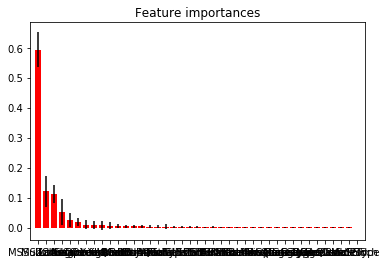

In [13]:
#Feature importances with random forest
# Build a forest and compute the feature importances
importances = regrF.feature_importances_
std = np.std([tree.feature_importances_ for tree in regrF.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

feature_keep =[]
feature_drop = []
for f in range(X.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], list(X)[indices[f]], importances[indices[f]]))
    if f < 20:
        feature_keep.append(list(X)[indices[f]])
    if f > 45:
        feature_drop.append(list(X)[indices[f]])
        
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center", tick_label=X_train.columns)
plt.xticks(range(X_train.shape[1]), X_train.columns)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
feature_drop

In [14]:
test2 = pd.read_csv('test.csv')


In [15]:
test2 = prepare_data(test2)


In [16]:
test2 = test2.drop(['Id'], 1)

In [ ]:
[print(i, list(test2)[i], np.unique(test2.iloc[:,i])) for i in range(1,101)]

In [17]:
predicted_regr_test = GBR.predict(test2)

In [18]:
#pour envoyer les données à Kaggle
sub = pd.read_csv('sample_submission.csv')
sub = pd.DataFrame(sub)
sub['SalePrice'] = predicted_regr_test
sub.to_csv('sample_submission_nat.csv', encoding='utf-8', index=False)